# Step 1: Read and Process Input Data

In [1]:
import os
import pprint

def read_data_with_occlusion_ratio(file_paths, output_folder):
    all_occlusion_ratios = []
    all_labels = set()

    os.makedirs(output_folder, exist_ok=True)
    output_file_path = os.path.join(output_folder, 'occlusion_data.txt')

    with open(output_file_path, 'w') as output_file:
    
        for file_path in file_paths:
            occlusion_ratios = {}
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split('\t')
                    filename = parts[0].split(": ")[1]                          # 'filename: xxxxxx.png'
                    combination_sequence = parts[1].split(": ")[1]              # 'sequence: big small big big'
                    success = parts[2].split(": ")[1].strip()                   # 'success: True/False'
                    combination = parts[3].split(": ")[1].strip()               # 'combination: big small big'
                    area_occluded_relative_to_bbox = parts[4].split(": ")[1].strip()  

                    sequence_length = len(combination_sequence.split())
                    combination_length = len(combination.split())
                    occlusion_ratio = combination_length / sequence_length

                    occlusion_ratio_key = f"{occlusion_ratio:.2f}"

                    if occlusion_ratio_key not in occlusion_ratios:
                        occlusion_ratios[occlusion_ratio_key] = {'True': 0, 'False': 0}
                    occlusion_ratios[occlusion_ratio_key][success] += 1

                    all_labels.add(occlusion_ratio_key)

            all_occlusion_ratios.append(occlusion_ratios)

            output_file.write(f"Data for {file_path}:\n")
            pprint.pprint(occlusion_ratios, stream=output_file)

    all_labels = sorted(all_labels, key=float)
    return all_occlusion_ratios, all_labels

file_paths = [
    'DETR_results_comparison_paper/results_comparison_real_500_deterministic1.txt',
    'DETR_results_comparison_paper/results_comparison_real_500_deterministic2.txt',
    'DETR_results_comparison_paper/results_comparison_real_500_deterministic3.txt',
    'DETR_results_comparison_paper/results_comparison_storage_box_labeled_deterministic1.txt',
    'DETR_results_comparison_paper/results_comparison_storage_box_labeled_deterministic2.txt',
    'DETR_results_comparison_paper/results_comparison_storage_box_labeled_deterministic3.txt',
    'DETR_results_comparison_paper/results_comparison_SD_V1_deterministic1.txt',
    'DETR_results_comparison_paper/results_comparison_SD_V1_deterministic2.txt',
    'DETR_results_comparison_paper/results_comparison_SD_V1_deterministic3.txt',
    'DETR_results_comparison_paper/results_comparison_SD_V2_deterministic1.txt',
    'DETR_results_comparison_paper/results_comparison_SD_V2_deterministic2.txt',
    'DETR_results_comparison_paper/results_comparison_SD_V2_deterministic3.txt'
]

output_folder = "DETR_results_occlusion"

# Read data and save pprint output to file
all_occlusion_ratios, all_labels = read_data_with_occlusion_ratio(file_paths, output_folder)

# Step 2: Process Data for Plotting

In [2]:
import ast

with open("DETR_results_occlusion/occlusion_data.txt", "r") as file:
    data_string = file.read()

all_data = {}
for block in data_string.strip().split("Data for ")[1:]:
    filename, data = block.split(":\n")
    all_data[filename.strip()] = ast.literal_eval(data.strip().replace("'", '"'))

occlusion_ratios = ["0.17", "0.20", "0.25", "0.33", "0.40", "0.50", "0.60", "0.67", "0.75", "0.80", "0.83", "1.00"]

with open("DETR_results_occlusion/occlusion_table.txt", "w") as output_file:
    for filename, data in all_data.items():
        output_file.write(f"\n{filename}:\n")
        output_file.write("Occlusion Ratio | Success Ratio | Data Points\n")
        output_file.write("----------------|---------------|------------\n")
        for ratio in occlusion_ratios:
            if ratio in data:
                true_val = data[ratio]['True']
                false_val = data[ratio]['False']
                success_ratio = true_val / (true_val + false_val)
                data_points = true_val + false_val
                output_file.write(f"{ratio:<15} | {success_ratio:.2f}          | {data_points}\n")
            else:
                output_file.write(f"{ratio:<15} |                | \n")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


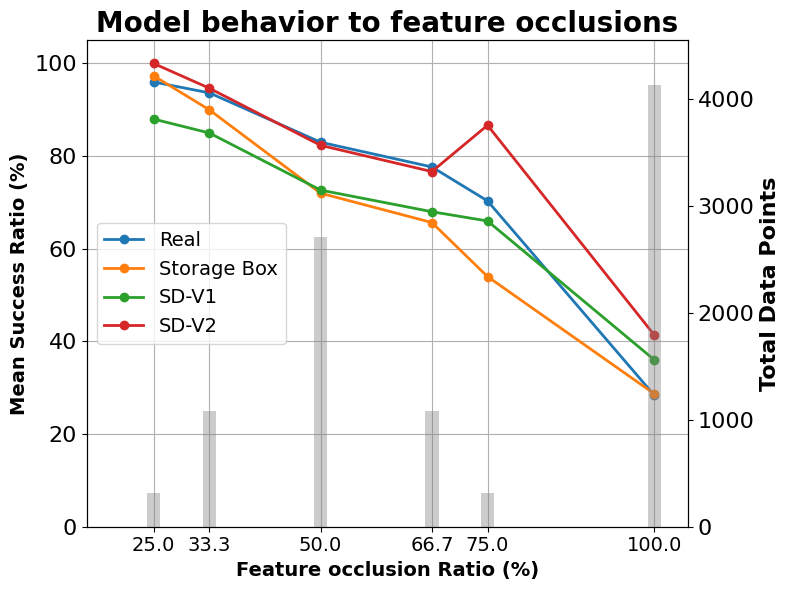

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import re

with open("DETR_results_occlusion/occlusion_table.txt", "r") as file:
    data = file.read()

dataset_groups = {
    "Real": ["DETR_results_comparison_paper/results_comparison_real_500_deterministic1.txt", 
             "DETR_results_comparison_paper/results_comparison_real_500_deterministic2.txt", 
             "DETR_results_comparison_paper/results_comparison_real_500_deterministic3.txt"],

    "Storage Box": ["DETR_results_comparison_paper/results_comparison_storage_box_labeled_deterministic1.txt",
                    "DETR_results_comparison_paper/results_comparison_storage_box_labeled_deterministic2.txt",
                    "DETR_results_comparison_paper/results_comparison_storage_box_labeled_deterministic3.txt"],

    "SD-V1": ["DETR_results_comparison_paper/results_comparison_SD_V1_deterministic1.txt",
              "DETR_results_comparison_paper/results_comparison_SD_V1_deterministic2.txt",
              "DETR_results_comparison_paper/results_comparison_SD_V1_deterministic3.txt"],

    "SD-V2": ["DETR_results_comparison_paper/results_comparison_SD_V2_deterministic1.txt",
              "DETR_results_comparison_paper/results_comparison_SD_V2_deterministic2.txt",
              "DETR_results_comparison_paper/results_comparison_SD_V2_deterministic3.txt"]
}

# Corrected occlusion ratios for accurate plotting
occlusion_ratios_corrected = {"0.17": 17.0, "0.20": 20.0, "0.25": 25.0, "0.33": 33.3333, "0.40": 40.0,
                              "0.50": 50.0, "0.60": 60.0, "0.67": 66.6667, "0.75": 75.0,
                              "0.80": 80.0, "0.83": 83.0, "1.00": 100.0}

parsed_data = {}
current_dataset = ""
for line in data.splitlines():
    if line.strip().endswith(":"):
        current_dataset = line.strip()[:-1]
        parsed_data[current_dataset] = {}
    elif re.match(r'^\d', line.strip()):
        parts = line.split('|')
        ratio = parts[0].strip()
        success_ratio = parts[1].strip()
        data_points = parts[2].strip()
        if success_ratio and data_points:
            parsed_data[current_dataset][ratio] = (float(success_ratio), int(data_points))

# Calculate mean success ratios for each group
group_means = {}
group_data_points = {}
for group, datasets in dataset_groups.items():
    means = []
    data_points_counts = []
    for ratio in occlusion_ratios_corrected:
        values = [parsed_data[dataset][ratio][0] for dataset in datasets 
                  if dataset in parsed_data and ratio in parsed_data[dataset]]
        data_counts = [parsed_data[dataset][ratio][1] for dataset in datasets 
                       if dataset in parsed_data and ratio in parsed_data[dataset]]
        mean_val = np.nanmean(values) if values else np.nan
        total_data_points = np.sum(data_counts)
        means.append(mean_val)
        data_points_counts.append(total_data_points)
    group_means[group] = means
    group_data_points[group] = data_points_counts

# Calculate total data points across all groups
combined_data_points = np.sum([group_data_points[group] for group in group_data_points], axis=0)

fig, ax1 = plt.subplots(figsize=(8, 6))

filtered_ratios = []
filtered_combined_points = []
ratios_list = list(occlusion_ratios_corrected.values())

# Filter based on combined data points (>300)
for i, data_count in enumerate(combined_data_points):
    if data_count > 300:
        filtered_ratios.append(ratios_list[i])
        filtered_combined_points.append(data_count)

for group in group_means:
    valid_ratios = []
    valid_means = []
    for i, ratio in enumerate(ratios_list):
        if ratio in filtered_ratios and not np.isnan(group_means[group][i]):
            valid_ratios.append(ratio)
            valid_means.append(group_means[group][i]*100)
    if valid_means:
        ax1.plot(valid_ratios, valid_means, marker='o', label=group, linewidth=2)

ax1.set_xlabel('Feature occlusion Ratio (%)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Mean Success Ratio (%)', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 105)

ax2 = ax1.twinx()
ax2.bar(filtered_ratios, filtered_combined_points, width=2, alpha=0.4, color='grey')
ax2.set_ylabel('Total Data Points', fontsize=16, fontweight='bold')
ax2.set_ylim(0, max(filtered_combined_points) * 1.1)

ax1.set_title('Model behavior to feature occlusions', fontsize=20, fontweight='bold')
ax1.legend(loc='center left', fontsize=14)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.set_xticks([25.0, 33.333333, 50.0, 66.666666, 75.0, 100.0])
ax1.set_xticklabels(['25.0', '33.3', '50.0', '66.7', '75.0', '100.0'], fontsize=14)
ax1.set_xlim(15, 105)

plt.tight_layout()

# Save the figure separately with high DPI for publication purposes
plt.savefig('DETR_results_occlusion/model_behavior_to_feature_occlusions.png', dpi=1200, bbox_inches='tight')
plt.savefig('DETR_results_occlusion/model_behavior_to_feature_occlusions.eps', format='eps', bbox_inches='tight')
plt.savefig('DETR_results_occlusion/model_behavior_to_feature_occlusions.pdf', format='pdf', bbox_inches='tight')

# Show interactive plot with normal DPI
plt.show()
